In [ ]:
%conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.6 -c pytorch -c nvidia
!python -m pip install cython pyyaml
!python -m pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [10]:
!python -m pip install -e detectron2

Obtaining file:///scratch/st-sielmann-1/agrobot/Weed-Detection/two-stage-detection/detectron2
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached yacs-0.1.8-py3-none-any.whl.metadata (639 bytes)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached fvcore-0.1.5.post20221221-py3-none-any.whl
  Using cached iopath-0.1.9-py3-none-any.whl.metadata (370 bytes)
  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached black-24.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.

In [11]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import typing

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

ModuleNotFoundError: No module named 'detectron2.utils'

In [3]:
from detectron2.data.datasets import register_coco_instances

TRAIN_DIR = "../datasets/Annotated-Images-for-Automated-Weed-Identification-and-Management/train"
TEST_DIR = "../datasets/Annotated-Images-for-Automated-Weed-Identification-and-Management/test"
register_coco_instances("weed_detection_train", {}, TRAIN_DIR + "/_annotations.coco.json", TRAIN_DIR)
register_coco_instances("weed_detection_test", {}, TEST_DIR + "/_annotations.coco.json", TEST_DIR)

In [ ]:
dataset_metadata = MetadataCatalog.get("weed_detection_train")
train_data: typing.List[typing.Dict] = DatasetCatalog.get("weed_detection_train")
test_data: typing.List[typing.Dict] = DatasetCatalog.get("weed_detection_test")

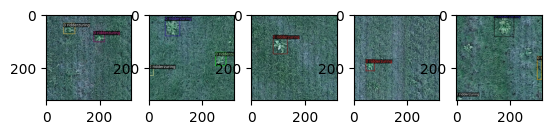

In [11]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(1, 5)
for i, data in enumerate(random.sample(train_data, 5)):
    img = cv2.imread(data["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(data)
    axarr[i].imshow(out.get_image()[:, :, ::-1])


In [ ]:
from detectron2.engine import DefaultTrainer
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("weed_detection_train",)
cfg.DATASETS.TEST = ("weed_detection_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1200
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()